## Define the Convolutional Neural Network

After you've looked at the data you're working with and, in this case, know the shapes of the images and of the keypoints, you are ready to define a convolutional neural network that can *learn* from this data.

In this notebook and in `models.py`, you will:
1. Define a CNN with images as input and keypoints as output
2. Construct the transformed FaceKeypointsDataset, just as before
3. Train the CNN on the training data, tracking loss
4. See how the trained model performs on test data
5. If necessary, modify the CNN structure and model hyperparameters, so that it performs *well* **\***

**\*** What does *well* mean?

"Well" means that the model's loss decreases during training **and**, when applied to test image data, the model produces keypoints that closely match the true keypoints of each face. And you'll see examples of this later in the notebook.

---


## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

You are required to use the above layers and encouraged to add multiple convolutional layers and things like dropout layers that may prevent overfitting. You are also encouraged to look at literature on keypoint detection, such as [this paper](https://arxiv.org/pdf/1710.00977.pdf), to help you determine the structure of your network.


### TODO: Define your model in the provided file `models.py` file

This file is mostly empty but contains the expected name and some TODO's for creating your model.

---

## PyTorch Neural Nets

To define a neural network in PyTorch, you define the layers of a model in the function `__init__` and define the feedforward behavior of a network that employs those initialized layers in the function `forward`, which takes in an input image tensor, `x`. The structure of this Net class is shown below and left for you to fill in.

Note: During training, PyTorch will be able to perform backpropagation by keeping track of the network's feedforward behavior and using autograd to calculate the update to the weights in the network.

#### Define the Layers in ` __init__`
As a reminder, a conv/pool layer may be defined like this (in `__init__`):
```
# 1 input image channel (for grayscale images), 32 output channels/feature maps, 3x3 square convolution kernel
self.conv1 = nn.Conv2d(1, 32, 3)

# maxpool that uses a square window of kernel_size=2, stride=2
self.pool = nn.MaxPool2d(2, 2)      
```

#### Refer to Layers in `forward`
Then referred to in the `forward` function like this, in which the conv1 layer has a ReLu activation applied to it before maxpooling is applied:
```
x = self.pool(F.relu(self.conv1(x)))
```

Best practice is to place any layers whose weights will change during the training process in `__init__` and refer to them in the `forward` function; any layers or functions that always behave in the same way, such as a pre-defined activation function, should appear *only* in the `forward` function.

#### Why models.py

You are tasked with defining the network in the `models.py` file so that any models you define can be saved and loaded by name in different notebooks in this project directory. For example, by defining a CNN class called `Net` in `models.py`, you can then create that same architecture in this and other notebooks by simply importing the class and instantiating a model:
```
    from models import Net
    net = Net()
```

In [1]:
# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [2]:
# import the usual resources
from pprint import pprint
import matplotlib.pyplot as plt
import numpy as np

I played a bit with transfer learning with VGG16 which uses 3-channel images as input whereas we only have a gray scale images for this project. I then have a GRAYSCALE variable to rapidly reconfigure the data transformations and network hyper-parameters.

The batch size is also configured from here, I'll discuss this parameter later on.

In [3]:
GRAYSCALE = True
BATCHSIZE = 32

I have built a dedicated class for this project which automates the CNN creation based on several hyper-parameters:

- `nb_features_map` provides the number of features map per convolutional layer
- `size_linear_layers` provides the the size and number of hidden layers in the fully-connected regressor (the output layer is created automatically)

The fully-connected layers are each followed by a dropout for regularization, to avoid overfitting. For the convolutional layer, the architecture is given by `conv_architecture`. This parameter is a string using C (for conv2d), P (for max-polling 2d), D (for dropout) or B (for batch normalization). It has helped me testing different architectures. The architecture is cycled, so in the following example each convolutional layer (4 in total with respectivelly 32, 32, 64, and 64 feature maps) is followed by a non-linear activation (rectified linear unit by default, or exponential linear unit), a max-pooling and a dropout. By using a CPD, we can replicate the architecture of CNN described in the following paper: https://arxiv.org/pdf/1710.00977.pdf inpired by LeNet, but it is also possible to replicate VGG16 architecture with CCPDCCPDCCCPDCCCPD.

It is also possible to specify a different size for each convolutional kernel with `conv_kernel_size` to either replicate the constant use of 3x3 kernel like in VGG16 or decreasing kernel size like in NaimishNet using 1x1 kernel size in the end. The max-pooling kernel size can be changed but I kept 2x2 kernels without overlapping for all my experimentations.

The following read provides explanation on the 1x1 kernel size:

- https://machinelearningmastery.com/introduction-to-1x1-convolutions-to-reduce-the-complexity-of-convolutional-neural-networks/

I have not tried to use a different pooling like average pooling: https://alexisbcook.github.io/2017/global-average-pooling-layers-for-object-localization/.

I made some tests with weight initialization in fully-connected layers using Xavier initialization (standard and uniform) but finally decided to stick with the Kaiming uniform which is the PyTorch default as I had the feeling that it leads to a better convergence. Some reading about Xavier and Kaiming initialization:

- https://pouannes.github.io/blog/initialization/
- https://prateekvjoshi.com/2016/03/29/understanding-xavier-initialization-in-deep-neural-networks/
- https://towardsdatascience.com/weight-initialization-in-neural-networks-a-journey-from-the-basics-to-kaiming-954fb9b47c79#:~:text=The%20aim%20of%20weight%20initialization,through%20a%20deep%20neural%20network.


I also made tests using exponential linear units in feature extractor and regressor but found that convergence was a bit more chaotic than with ReLU. I haven't really tried to fix this behaviour by playing with weight initialization (using a different gain -https://pytorch.org/docs/stable/nn.init.html#torch-nn-init-) or by adapting optimizer parameters. The following read discusses the pro's and con's of different activation functions:

- https://mlfromscratch.com/activation-functions-explained/#the-good-and-the-bad-properties-of-dead-relus

The class I have implemented also enables to set the stride of max-pooling and convolutional layer as well as padding. In all my tests I have kept non-overlapping max-pooling (kernel size 2x2 with stride 2 with no zero padding). I made some tests with zero-padding for convolutional layer (either SAME with zero-padding or VALID with no zero-padding). For a given feature extractor architecture, the number of ouput features using zero-padding is significantly greater than with no zero-padding. Zero-padding might not be as useful on the first layers of convolutional layers but shall have a more significance impact of subsequent layers. I made no specific test to validate this assumption. Resources about padding:

- https://medium.com/@ayeshmanthaperera/what-is-padding-in-cnns-71b21fb0dd7
- https://deeplizard.com/learn/video/qSTv_m-KFk0

I made some experiments between batch normalization and dropout. I have kept dropout for fully-connected regressor but I have tested dropout and batch normalization for feature extractor, and decided to stick with batch normalization. The differences are illustrated below. I have used the following materials for regularization:

- https://machinelearningmastery.com/dropout-regularization-deep-learning-models-keras/
- https://towardsdatascience.com/batch-normalization-and-dropout-in-neural-networks-explained-with-pytorch-47d7a8459bcd
- https://www.kdnuggets.com/2018/09/dropout-convolutional-networks.html#:~:text=For%20all%20other%20regions%20you,model%20more%20stable%20during%20training.

The class enables to use a variable dropout probability like in the NaimishNet architecture but I have not performed any experiment with it.

As another form of regularization, I have been using weight decay or L2 regularization either in Adam (including AdamW variant (https://pytorch.org/docs/stable/optim.html#torch.optim.AdamW)) or SGD with momentum of 0.9. I found better convergence with Adam-like optimizers than with SGD. The following read is about weight decay:

- https://www.fast.ai/2018/07/02/adam-weight-decay/

I also tried different batch sizes. I started with a batch size of 10 but rapidly increased it to 64 and even 96 for simpler CNN's. I found that with a small size the convergence is poor and that convergence is slow with batch larger than 32, this is the final value I use. Actually I struggled a lot having a decent accuracy, made a lot of tests of architecture and then finally realized that I just had to increase the batch size. A larger batch size improves speed (number of images per second processed during learning) but requires more video RAM. As my GPU only has 4GB I needed to reduce the batch size when trying bigger CNN's as low as 8 for a VGG16 like architecture. Which might have a negative impact on convergence. I did not managed to make such a complex architecture converge due to another mistake I've made. I will discuss later. But I would admit that I have overlooked batch size importance. Article I have used:

- https://medium.com/mini-distill/effect-of-batch-size-on-training-dynamics-21c14f7a716e

To sort out the issue I was facing with batch size I have used transfer learning. My parametric model also enables to use a pretrained model (VGG16) as feature extractor. I had been uisng this technique on a previous project and was able to make it work effectively. But in this project it still failed to provide good accuracy and this is how I realized that my problem was coming from something different than the network architecture.

When building the parametric CNN, I also found usefull to predict what would be the size of tensors after each layer. It helped a lot for the first layer of fully connected layer but also helped me better feel the dimensions changes after each type of layer.

I also have used information from this article:

- https://medium.com/@dipti.rohan.pawar/improving-performance-of-convolutional-neural-network-2ecfe0207de7

I have been using cross-validation on previous experiences with machine learning, not only Artificial Neuron Networks but I have not used this for the current project. I haven't be using early stoppong technique and over-fitting is mostly prevented in my experiments with regularization of loss through weight decay and using dropout or batch normalization to prevent certain node to become dominant in the network.

Other articles related to facial keypoints detection I have used:

- https://medium.com/diving-in-deep/facial-keypoints-detection-with-pytorch-86bac79141e4

In [4]:
import torch
from models import Net

net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], conv_architecture="CPD",
          conv_kernel_size=5, pool_kernel_size=2, pool_stride=2, grayscale=GRAYSCALE)
print(net)

Net(
  (cnn): Module(
    (extractor): Sequential(
      (conv2d-01): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (relu-01): ReLU()
      (maxpool2d-01): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout-01): Dropout(p=0.3, inplace=False)
      (conv2d-02): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (relu-02): ReLU()
      (maxpool2d-02): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout-02): Dropout(p=0.3, inplace=False)
      (conv2d-03): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (relu-03): ReLU()
      (maxpool2d-03): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (dropout-03): Dropout(p=0.3, inplace=False)
      (conv2d-04): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
      (relu-04): ReLU()
      (maxpool2d-04): MaxPool2d(kernel_size=2, stride=2, padding=0, dilat

It is possible to get the shapes of all layers:

In [5]:
net.shapes

[('input', 1, 224, 224),
 ('conv2d-01', 32, 222, 222),
 ('relu-01', 32, 222, 222),
 ('maxpool2d-01', 32, 111, 111),
 ('dropout-01', 32, 111, 111),
 ('conv2d-02', 32, 109, 109),
 ('relu-02', 32, 109, 109),
 ('maxpool2d-02', 32, 54, 54),
 ('dropout-02', 32, 54, 54),
 ('conv2d-03', 64, 52, 52),
 ('relu-03', 64, 52, 52),
 ('maxpool2d-03', 64, 26, 26),
 ('dropout-03', 64, 26, 26),
 ('conv2d-04', 64, 24, 24),
 ('relu-04', 64, 24, 24),
 ('maxpool2d-04', 64, 12, 12),
 ('dropout-04', 64, 12, 12),
 ('flatten', 9216),
 ('linear-01', 1024),
 ('relu-01', 1024),
 ('dropout-01', 1024),
 ('linear-02', 512),
 ('relu-02', 512),
 ('dropout-02', 512),
 ('output', 136)]

Or to calculate the number of parameters, the first value returned is the number of parameters to be trained, the second one is the total number of parameters:

In [6]:
net.count_parameters()

(10212968, 10212968)

## Transform the dataset 

To prepare for training, create a transformed dataset of images and keypoints.

### TODO: Define a data transform

In PyTorch, a convolutional neural network expects a torch image of a consistent size as input. For efficient training, and so your model's loss does not blow up during training, it is also suggested that you normalize the input images and keypoints. The necessary transforms have been defined in `data_load.py` and you **do not** need to modify these; take a look at this file (you'll see the same transforms that were defined and applied in Notebook 1).

To define the data transform below, use a [composition](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#compose-transforms) of:
1. Rescaling and/or cropping the data, such that you are left with a square image (the suggested size is 224x224px)
2. Normalizing the images and keypoints; turning each RGB image into a grayscale image with a color range of [0, 1] and transforming the given keypoints into a range of [-1, 1]
3. Turning these images and keypoints into Tensors

These transformations have been defined in `data_load.py`, but it's up to you to call them and create a `data_transform` below. **This transform will be applied to the training data and, later, the test data**. It will change how you go about displaying these images and keypoints, but these steps are essential for efficient training.

As a note, should you want to perform data augmentation (which is optional in this project), and randomly rotate or shift these images, a square image size will be useful; rotating a 224x224 image by 90 degrees will result in the same shape of output.

### Differences with provided transformations

The transforms are the same the the one provided as input for the project but with the following differences:
- The normalization may or may not convert image to gray scale, I mostly used this to test building a facial keypoint detector with transfer learning
- I have added a data augmentation which slighly rotate the image (and the keypoints) in the training set by an angle between -45 and 45 degrees.
- I have added a random flip as well for data augmentation.

I have made some experiments with and without the data augmentation. The rotation is implemented with OpenCV [cv2.getRotationMatrix2D](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=warpaffine#Mat%20getRotationMatrix2D(Point2f%20center,%20double%20angle,%20double%20scale)) and [cv2.warpAffine](https://docs.opencv.org/2.4/modules/imgproc/doc/geometric_transformations.html?highlight=warpaffine#void%20warpAffine(InputArray%20src,%20OutputArray%20dst,%20InputArray%20M,%20Size%20dsize,%20int%20flags,%20int%20borderMode,%20const%20Scalar&%20borderValue)). The only subtle part in this process is that I had to convert key points coordinates to [homogeneous coordinates](https://en.wikipedia.org/wiki/Homogeneous_coordinates) in order to use the same rotation matrix as the one for the image.

In [7]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, RandomRotate, RandomFlip, ToTensor

## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
train_transform = transforms.Compose([Rescale(250),
                                     RandomRotate(45.),
                                     RandomCrop(224),
                                     Normalize(grayscale=GRAYSCALE),
                                     ToTensor()
                                    ])

# testing that you've defined a transform
assert(train_transform is not None), 'Define a data_transform'

In [8]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='/files/cedric/datasets/udacity/ai_nanodegree/facial_keypoints/training_frames_keypoints.csv',
                                             root_dir='/files/cedric/datasets/udacity/ai_nanodegree/facial_keypoints/training/',
                                             transform=train_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462
0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


### Issues with data augmentation

I had major issue with data augmentation. For a reason that is still unknown to me there is a problem in my random flip data augmentation. When testing the transform on training samples it seems to behave as expected and properly flip the image and the key points. BUT it seems it's not the case anymore when training the model. My models were not able to converge to a good solution. I then realized that right from the first epoch, the predicted key points were on a vertical line in the middle of the image and this does not change whatever the number of epochs.

It then has introduced a high bias in my model. I thought that the issue was coming from my network architecture and then made a lot of tests without fixing the issue. I then opted to test with a pretrained VGG16 I know would work. But it doesn't either. So I have looked to other things, and I have switched-off data augmentation transforms until I realize that issue was coming from random flip... I decided to let this problem aside for the moment and go on with the project.

I only have used data augmentation on the training samples, not on the validation samples. I have added in the fit algorithm an assessment of the loss on the testing sample to have a better view on potential overfitting.

I found that convergence of model with data augmentation is slower than without any augmentation (all other things being equal: batch size, CNN architecture...). As I evaluate the models on a non-augmented validation set, the overall score is the same. But I assume that on an data-augmented test dataset the accuracy would have been better with the model trained with data-augmented training set and that it would generalize better.

## Batching and loading data

Next, having defined the transformed dataset, we can use PyTorch's DataLoader class to load the training data in batches of whatever size as well as to shuffle the data for training the model. You can read more about the parameters of the DataLoader, in [this documentation](http://pytorch.org/docs/master/data.html).

#### Batch size
Decide on a good batch size for training your model. Try both small and large batch sizes and note how the loss decreases as the model trains.

**Note for Windows users**: Please change the `num_workers` to 0 or you may face some issues with your DataLoader failing.

In [9]:
# load training data in batches
train_loader = DataLoader(transformed_dataset, 
                          batch_size=BATCHSIZE,
                          shuffle=True, 
                          num_workers=4)

## Before training

Take a look at how this model performs before it trains. You should see that the keypoints it predicts start off in one spot and don't match the keypoints on a face at all! It's interesting to visualize this behavior so that you can compare it to the model after training and see how the model has improved.

#### Load in the test dataset

The test dataset is one that this model has *not* seen before, meaning it has not trained with these images. We'll load in this test data and before and after training, see how your model performs on this set!

To visualize this test data, we have to go through some un-transformation steps to turn our images into python images from tensors and to turn our keypoints back into a recognizable range.

For the test dataset, I am not using the data augmentation transforms (random crop and random rotate), the rescale transform is such it resizes images to the expected height and width.

#### Note about the data augmentation

The data augmentation (rotation and random crop) is turn off in the testing transform.

In [10]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above
test_transform = transforms.Compose([Rescale((224, 224)),
                                     Normalize(grayscale=GRAYSCALE),
                                     ToTensor()
                                    ])

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='/files/cedric/datasets/udacity/ai_nanodegree/facial_keypoints/test_frames_keypoints.csv',
                                      root_dir='/files/cedric/datasets/udacity/ai_nanodegree/facial_keypoints/test/',
                                      transform=test_transform)

In [11]:
# load test data in batches
test_loader = DataLoader(test_dataset, 
                          batch_size=BATCHSIZE,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

To test the model on a test sample of data, you have to follow these steps:
1. Extract the image and ground truth keypoints from a sample
2. Make sure the image is a FloatTensor, which the model expects.
3. Forward pass the image through the net to get the predicted, output keypoints.

This function test how the network performs on the first batch of test data. It returns the images, the transformed images, the predicted keypoints (produced by the model), and the ground truth keypoints.

In [12]:
# test the model on a batch of test images

def net_sample_output(net, loader):
    
    # iterate through the test dataset
    for i, sample in enumerate(loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        #output_pts = net(images)
        output_pts = net.predict(images)
        
        # reshape to batch_size x 68 x 2 pts
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        
        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

#### Debugging tips

If you get a size or dimension error here, make sure that your network outputs the expected number of keypoints! Or if you get a Tensor type error, look into changing the above code that casts the data into float types: `images = images.type(torch.FloatTensor)`.

In [13]:
# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
test_images, test_outputs, gt_pts = net_sample_output(net, train_loader)

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


## Visualize the predicted keypoints

Once we've had the model produce some predicted output keypoints, we can visualize these points in a way that's similar to how we've displayed this data before, only this time, we have to "un-transform" the image/keypoint data to display it.

Note that I've defined a *new* function, `show_all_keypoints` that displays a grayscale image, its predicted keypoints and its ground truth keypoints (if provided).

In [14]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


#### Un-transformation

Next, you'll see a helper function. `visualize_output` that takes in a batch of images, predicted keypoints, and ground truth keypoints and displays a set of those images and their true/predicted keypoints.

This function's main role is to take batches of image and keypoint data (the input and output of your CNN), and transform them into numpy images and un-normalized keypoints (x, y) for normal display. The un-transformation process turns keypoints and images into numpy arrays from Tensors *and* it undoes the keypoint normalization done in the Normalize() transform; it's assumed that you applied these transformations when you loaded your test data.

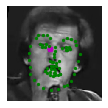

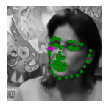

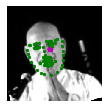

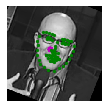

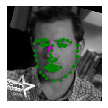

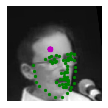

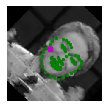

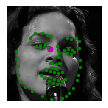

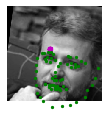

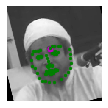

In [15]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss, you may want to choose a loss function that is suited for regression, which directly compares a predicted value and target value. Read about the various kinds of loss functions (like MSE or L1/SmoothL1 loss) in [this documentation](http://pytorch.org/docs/master/_modules/torch/nn/modules/loss.html).

### TODO: Define the loss and optimization

Next, you'll define how the model will train by deciding on the loss function and optimizer.

---

I have included the loss and optimizer configuration in the models.py itself. I have chosen a Mean Squared Error (L2) loss with a mean reduction with Adam, AdamW or SGD as described above.

Some references I have used:

https://towardsdatascience.com/why-adamw-matters-736223f31b5d

https://datascience.stackexchange.com/questions/30344/why-not-always-use-the-adam-optimization-technique/30347

https://discuss.pytorch.org/t/how-to-add-a-l2-regularization-term-in-my-loss-function/17411

## Training and Initial Observation

Now, you'll train on your batched training data from `train_loader` for a number of epochs. 

To quickly observe how your model is training and decide on whether or not you should modify it's structure or hyperparameters, you're encouraged to start off with just one or two epochs at first. As you train, note how your the model's loss behaves over time: does it decrease quickly at first and then slow down? Does it take a while to decrease in the first place? What happens if you change the batch size of your training data or modify your loss function? etc. 

Use these initial observations to make changes to your model and decide on the best architecture before you train for many epochs and create a final model.

I have made a function to make some kind of grid search to find the best hyper-parameters:

In [16]:
import itertools
import json
import uuid
import os


def grid_search(params, train_loader, test_loader, limit=None, output="trades.json", epochs=40):
    best_valid_loss, best_net = 1000.0, None
    if os.path.exists(output):
        with open(output, 'r') as fobj:
            trades = json.loads(fobj.read())
    else:
        trades = {}
    for uid, trade in trades.items():
        if trade["valid_losses"]:
            if trade["valid_losses"][-1] < best_valid_loss:
                best_valid_loss = trade["valid_losses"][-1]
                best_net = uid
    count = 0
    param_keys, param_values = [], []
    for key, value in params.items():
        param_keys.append(key)
        param_values.append(value)
    for combination in itertools.product(*param_values):
        config = {param_keys[i]: value for i, value in enumerate(combination)}
        pprint(config)
        found = False
        for trade in trades:
            if trades[trade]["config"] == config:
                print("Skip configuration as it has already been performed.")
                found = True
                break
        if found:
            continue
        try:
            net = Net(**config)
        except:
            continue
        else:
            print(net)
            pprint(net.shapes)
        try:
            net_sample_output(net)
        except:
            continue
        record = {}
        record["nb_parameters"] = net.count_parameters()
        record["shapes"] = net.shapes
        try:
            train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, epochs)
        except:
            break
        else:
            count += 1
            uid = str(uuid.uuid4())
            record["config"] = config
            record["train_losses"] = train_losses
            record["valid_losses"] = valid_losses
            record["elapsed_times"] = elapsed_times
            record["batch_size"] = BATCHSIZE
            if valid_losses:
                if valid_losses[-1] < best_valid_loss:
                    best_valid_loss = valid_losses[-1]
                    best_net = uid
                    print("This is the best Net {} so far with a valid loss of {} !"
                          .format(uid, best_valid_loss))
                    net.save(f"./saved_models/{uid}")
            del train_losses, valid_losses, elapsed_times
            trades[uid] = record
            with open(output, 'w') as fobj:
                fobj.write(json.dumps(trades, indent=4))
        if limit is not None and count > limit:
            break

In [17]:
def plot_convergence(train_losses, valid_losses):
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(train_losses, c='#F4511E', label="Train loss")
    ax.plot(valid_losses, c='#00ACC1', label="Valid loss")
    ax.axhline(valid_losses[-1], ls="--", c='k')
    ax.annotate("{:.3f}".format(valid_losses[-1]), 
                (len(valid_losses)/2., valid_losses[-1] + 0.003),
                ha="center", va="bottom")
    ax.set_xlabel("epochs")
    ax.set_ylabel("loss")
    ax.legend()

The following defines hyper-parameters list for the grid search. This technique appeared to be extremly time consumming. This is what I have used when I was struggling with both batch size and my data augmentation issue on random flip. Having a closer look at actual predictions on images earlier would have spared me and my GPU some calculations ;)

But as this is the first CNN I have trained, I find quite difficult:

- to have a rough idea of the model complexity for this specific task and I mostly interpret the unability of the model to convergence to the network architecture itself. Several tests with different complexities of model all lead to the same bad results, this should have told me that the problem was NOT the architecture
- to have a good feeling on how many epochs would be needed: is there any interest in having more epoch ?

Transfer learning with VGG16 has been a big help in identifying that my problem was not coming from network architecture but from:

- batch size
- data augmentation issue

In [18]:
# CPD architecture (like the one from https://arxiv.org/pdf/1710.00977.pdf)
# params = {
#     "nb_features_map": [[32, 32, 64, 64]],
#     "size_linear_layers": [[1024, 1024], [1024]],
#     "dropout_rate": [0.2, (0.1, 0.1)],
#     "conv_kernel_size": [3, [4, 3, 2, 1]],
#     "conv_stride": [1],
#     "conv_padding": [0, 1],
#     "conv_activation": ["relu"],
#     "conv_architecture": ["CPD"],
#     "pool_kernel_size": [2],
#     "pool_stride": [2],
#     "dense_activation": ["relu"],
#     "optimizer": ["Adam"],
#     "learning_rate": [0.001],
#     "weight_decay": [0.],
#     "grayscale": [GRAYSCALE],
#     "pretrained": [None],
# }
params = {
    "nb_features_map": [[8, 8, 16, 16]],
    "size_linear_layers": [[256, 256], [256]],
    "dropout_rate": [0.2, (0.1, 0.1)],
    "conv_kernel_size": [3, [4, 3, 2, 1]],
    "conv_stride": [1],
    "conv_padding": [0, 1],
    "conv_activation": ["relu"],
    "conv_architecture": ["CPD"],
    "pool_kernel_size": [2],
    "pool_stride": [2],
    "dense_activation": ["relu"],
    "optimizer": ["Adam"],
    "learning_rate": [0.001],
    "weight_decay": [0.],
    "grayscale": [GRAYSCALE],
    "pretrained": [None],
}

In [19]:
# grid_search(params, train_loader, test_loader, limit=None, epochs=20)

Apart from grid search I made several manual tries. I kept them in comment to remember the different tries I have made but valid losses reported are not accurate because I had introduced a bias with my data augmentations.

In [1067]:
## First try, 0.017 valid loss after 20 epochs
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# Add one dense layer, 0.017 valid loss after 20 epochs
#net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
#          conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#          learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# Add convolution layer, 0.023 valid loss after 20 epochs
# net = Net(nb_features_map=[32, 32, 64, 64, 64], size_linear_layers=[1024], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# Increase number of features map, 0.021 valid loss after 20 epochs
# net = Net(nb_features_map=[32, 64, 128, 256], size_linear_layers=[1024], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# Increase number dense layer and size, 0.024 valid loss after 20 epochs
#net = Net(nb_features_map=[32, 64, 128, 256], size_linear_layers=[2048, 1024], 
#          conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#          learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# Increase kernel size, 0.016 valid loss after 20 epochs
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024], 
#           conv_kernel_size=[4, 4, 4, 4], pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# Move to AdamW (includes a L2 regularization), 0.016 valid loss after 20 epochs
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024], 
#           conv_kernel_size=[4, 4, 4, 4], pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu", 
#           optimizer="AdamW")
# Reduce number of layers, 0.021 valid loss after 20 epochs
# net = Net(nb_features_map=[32, 64, 64], size_linear_layers=[1024], 
#           conv_kernel_size=[4, 3, 2], pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu", 
#           optimizer="AdamW")
# # Naive try, valid loss 0.031 after 20 epochs
# net = Net(nb_features_map=[8, 8, 8], size_linear_layers=[256], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Reduce size of dense layer, valid loss 0.040 after 20 epochs
# net = Net(nb_features_map=[8, 8, 8], size_linear_layers=[128], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Add a convolution layer, valid loss 0.038 after 20 epochs
# net = Net(nb_features_map=[8, 8, 8, 8], size_linear_layers=[256], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Test with padding, valid loss 0.043 after 20 epochs
# net = Net(nb_features_map=[8, 8, 8], size_linear_layers=[256], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=1, conv_activation="relu", dense_activation="relu")
# # Reduce dropout, valid loss 0.034 after 20 epochs
# net = Net(nb_features_map=[8, 8, 8], size_linear_layers=[256], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.1, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # 4 conv layers, valid loss 0.027 after 20 epochs
# net = Net(nb_features_map=[8, 8, 16, 16], size_linear_layers=[256], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # decreasing kernel size, valid loss 0.050 after 20 epochs
# net = Net(nb_features_map=[8, 8, 16, 16], size_linear_layers=[256], 
#           conv_kernel_size=[4, 3, 2, 1], pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Doubling feature maps, valid loss 0.020 after 20 epochs
# net = Net(nb_features_map=[16, 16, 32, 32], size_linear_layers=[256], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Doubling again feature maps, 0.018 valid loss  after 20 epochs
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[256], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Trying with a pretrained model, 0.023 valid loss after 10 epochs with a batch size of 10
# net = Net(pretrained="VGG16", dropout_rate=0.2, size_linear_layers=[1024], learning_rate=0.001, 
#           dense_activation="relu")
# # Trying with a pretrained model, 0.017 valid loss after 20 epochs with a batch size of 32
# net = Net(pretrained="VGG16", dropout_rate=0.2, size_linear_layers=[1024], learning_rate=0.001, 
#           dense_activation="relu")
# # Increasing the batch size to 96, 0.024 valid loss after 40 epochs with a batch size of 96
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[256], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Increase the learning rate, 0.057 valid loss after 20 epochs with batch size 96
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[256], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.01, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Introducing weight decay, 0.055 valid loss  after 20 epochs and batch size of 96
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[256], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, weight_decay=0.01,
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # More complexity on the classifier, 0.031 valid loss after 20 epochs and batch size of 64
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Going back to a batch size of 64, 0.016 valid loss after 40 epochs
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[256], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Trying with SGD and learning rate of 0.01, 0.016 valid loss after 40 epochs
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[256], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, optimizer="SGD",
#           learning_rate=0.01, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Deeper classifier, 0.012 valid loss after 60 epochs
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 1024], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Increase learning rate,  valid loss after 60 epochs
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 1024], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.01, conv_padding=0, conv_activation="relu", dense_activation="relu")
# Increasing dropout to limit over-fitting and use SGD with momentum,  valid loss after 20 epochs
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 1024], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0., 
#           learning_rate=0.01, conv_padding=0, conv_activation="relu", dense_activation="relu", 
#           optimizer="SGD")
# # Data augmentation with rotation,  valid loss after 60 epochs
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 1024], grayscale=GRAYSCALE,
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# Trying with a pretrained model, 0.017 valid loss after 20 epochs with a batch size of 32
# net = Net(pretrained="VGG16", dropout_rate=0.2, size_linear_layers=[1024], learning_rate=0.001, 
#           dense_activation="relu")
## Without data augmentation, 0.007 valid loss after 20 epochs with batch size 32
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, conv_architecture="CPD",
#           learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu")
# # Much much deeper with VGG16-like architecture,  valid loss after 20 epochs with batch size 16
# net = Net(nb_features_map=[64, 64, 128, 128, 256, 256, 256, 512, 512, 512], 
#           size_linear_layers=[2048, 1024], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
#           conv_architecture="CCPDCCPDCCCPDCCCPDCCCPD", learning_rate=0.001, conv_padding=0, 
#           conv_activation="relu", dense_activation="relu", optimizer="Adam")
# # Turn randomcrop on, 0.012 valid loss after 40 epochs with batch size 32
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.1, 
#           conv_architecture="CPD", learning_rate=0.001, conv_padding=0, conv_activation="relu", 
#           dense_activation="relu", optimizer="AdamW")
# # Increase batch to 64, 0.011 valid loss after 40 epochs with batch size 64
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.1, 
#           conv_architecture="CPD", learning_rate=0.001, conv_padding=0, conv_activation="relu", 
#           dense_activation="relu", optimizer="AdamW")
## Activate random flip, 0.035 valid loss after 40 epochs with batch size 64
# net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.1, 
#           conv_architecture="CPD", learning_rate=0.001, conv_padding=0, conv_activation="relu", 
#           dense_activation="relu", optimizer="AdamW")
# # Try to augment model capacity, 0.035 valid loss after 40 epochs with batch size 64
# net = Net(nb_features_map=[64, 64, 128, 128, 256, 256, 256, 512, 512, 512, 512, 512, 512], 
#           size_linear_layers=[2048, 1024], 
#           conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.5, 
#           conv_architecture="CCPBCCPBCCCPBCCCPBCCCPB", learning_rate=0.001, conv_padding=1, 
#           conv_activation="relu", dense_activation="relu", optimizer="AdamW")

I have used my GPU (NVidia GeForce 970 GTX with 4GB of DDR5 VRAM and 1664 CUDA cores) for training.

The first test is a simple CNN with 4 layers (with respectively 32, 32, 64, and 64 features map). The kernel size is 3x3 for all layers. I am not using zero-padding. Maxpooling is used with no overlapping and a kernel size of 2x2. I use Rectified Linear Unit as activation function on all layers and dropout for regularization. In the network, each convolutional layer is followed by activation function, max-pooling and then dropout. The optimizer is Adam with a learning rate of 0.001 and no weight decay.

With these settings, the first part of network extracts 9216 features and 9.6 millions of parameters need to be trained. I am using 20 epochs to see the convergence profile.

[('input', 1, 224, 224),
 ('conv2d-01', 32, 222, 222),
 ('relu-01', 32, 222, 222),
 ('maxpool2d-01', 32, 111, 111),
 ('dropout-01', 32, 111, 111),
 ('conv2d-02', 32, 109, 109),
 ('relu-02', 32, 109, 109),
 ('maxpool2d-02', 32, 54, 54),
 ('dropout-02', 32, 54, 54),
 ('conv2d-03', 64, 52, 52),
 ('relu-03', 64, 52, 52),
 ('maxpool2d-03', 64, 26, 26),
 ('dropout-03', 64, 26, 26),
 ('conv2d-04', 64, 24, 24),
 ('relu-04', 64, 24, 24),
 ('maxpool2d-04', 64, 12, 12),
 ('dropout-04', 64, 12, 12),
 ('flatten', 9216),
 ('linear-01', 1024),
 ('relu-01', 1024),
 ('dropout-01', 1024),
 ('output', 136)]
(9642600, 9642600)
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 351.3 Running loss: 0.327 Elapsed time: 9.9 seconds 
Epoch: 1/20 Training loss: 0.327 Valid loss: 0.066
Epoch completion: 100.0% Images per second: 330.9 Running loss: 0.257 Elapsed time: 20.9 seconds 
Epoch: 2/20 Training loss: 0.257 Valid loss: 0.058
Epoch completion: 100.0% Images per second: 32

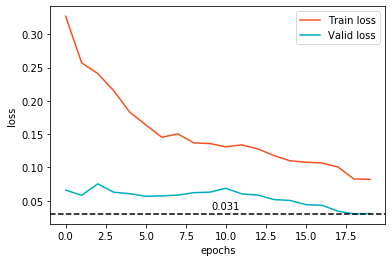

In [1074]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024], 
          conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, conv_architecture="CPD",
          learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu",
          optimizer="Adam")
pprint(net.shapes)
print(net.count_parameters())
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 20)
plot_convergence(train_losses, valid_losses);

I am now replacing dropout by batch normalization, the number of parameters to be trained slightly increases due to the parameters introduced by the batch normalization itself. Dropout is still used in the regressor part of the network.

[('input', 1, 224, 224),
 ('conv2d-01', 32, 222, 222),
 ('relu-01', 32, 222, 222),
 ('maxpool2d-01', 32, 111, 111),
 ('batchnorm-01', 32, 111, 111),
 ('conv2d-02', 32, 109, 109),
 ('relu-02', 32, 109, 109),
 ('maxpool2d-02', 32, 54, 54),
 ('batchnorm-02', 32, 54, 54),
 ('conv2d-03', 64, 52, 52),
 ('relu-03', 64, 52, 52),
 ('maxpool2d-03', 64, 26, 26),
 ('batchnorm-03', 64, 26, 26),
 ('conv2d-04', 64, 24, 24),
 ('relu-04', 64, 24, 24),
 ('maxpool2d-04', 64, 12, 12),
 ('batchnorm-04', 64, 12, 12),
 ('flatten', 9216),
 ('linear-01', 1024),
 ('relu-01', 1024),
 ('dropout-01', 1024),
 ('output', 136)]
(9642984, 9642984)
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 302.6 Running loss: 0.240 Elapsed time: 11.4 seconds 
Epoch: 1/20 Training loss: 0.240 Valid loss: 0.114
Epoch completion: 100.0% Images per second: 285.4 Running loss: 0.139 Elapsed time: 24.3 seconds 
Epoch: 2/20 Training loss: 0.139 Valid loss: 0.054
Epoch completion: 100.0% Images per s

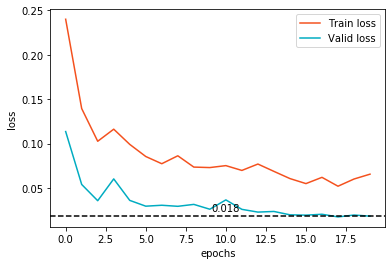

In [1078]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024], 
          conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, conv_architecture="CPB",
          learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu",
          optimizer="Adam")
pprint(net.shapes)
print(net.count_parameters())
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 20)
plot_convergence(train_losses, valid_losses);

The valid loss reached after 20 epochs is lower with batch normalization, I will go with batch normalization instead of dropout in the feature extractor.

The regressor now has an additional hidden layer. The number of extracted features is still 9216 but the number of parameters to be trained increases to 10 millions.

[('input', 1, 224, 224),
 ('conv2d-01', 32, 222, 222),
 ('relu-01', 32, 222, 222),
 ('maxpool2d-01', 32, 111, 111),
 ('batchnorm-01', 32, 111, 111),
 ('conv2d-02', 32, 109, 109),
 ('relu-02', 32, 109, 109),
 ('maxpool2d-02', 32, 54, 54),
 ('batchnorm-02', 32, 54, 54),
 ('conv2d-03', 64, 52, 52),
 ('relu-03', 64, 52, 52),
 ('maxpool2d-03', 64, 26, 26),
 ('batchnorm-03', 64, 26, 26),
 ('conv2d-04', 64, 24, 24),
 ('relu-04', 64, 24, 24),
 ('maxpool2d-04', 64, 12, 12),
 ('batchnorm-04', 64, 12, 12),
 ('flatten', 9216),
 ('linear-01', 1024),
 ('relu-01', 1024),
 ('dropout-01', 1024),
 ('linear-02', 512),
 ('relu-02', 512),
 ('dropout-02', 512),
 ('output', 136)]
(10098152, 10098152)
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 311.6 Running loss: 0.221 Elapsed time: 11.1 seconds 
Epoch: 1/20 Training loss: 0.221 Valid loss: 0.109
Epoch completion: 100.0% Images per second: 298.1 Running loss: 0.128 Elapsed time: 23.2 seconds 
Epoch: 2/20 Training los

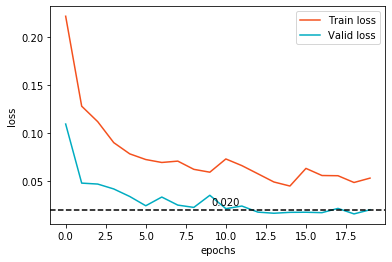

In [1077]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
          conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, conv_architecture="CPB",
          learning_rate=0.001, conv_padding=0, conv_activation="relu", dense_activation="relu",
          optimizer="Adam")
pprint(net.shapes)
print(net.count_parameters())
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 20)
plot_convergence(train_losses, valid_losses);

The accuracy of the network is slightly improved when using an additional layer in the regressor. I will keep this additional layer for the next experiments.

At this stage, I turn the zero-padding on for convolutional layers. This increases the number of extracted features to 12544 due to the lower dimensionnality reduction brought by zero-padding in convolutional layers. The number of parameters increases to 13.5 millions mostly due to additional weights to be learned in the first layer of regressor.

[('input', 1, 224, 224),
 ('conv2d-01', 32, 224, 224),
 ('relu-01', 32, 224, 224),
 ('maxpool2d-01', 32, 112, 112),
 ('batchnorm-01', 32, 112, 112),
 ('conv2d-02', 32, 112, 112),
 ('relu-02', 32, 112, 112),
 ('maxpool2d-02', 32, 56, 56),
 ('batchnorm-02', 32, 56, 56),
 ('conv2d-03', 64, 56, 56),
 ('relu-03', 64, 56, 56),
 ('maxpool2d-03', 64, 28, 28),
 ('batchnorm-03', 64, 28, 28),
 ('conv2d-04', 64, 28, 28),
 ('relu-04', 64, 28, 28),
 ('maxpool2d-04', 64, 14, 14),
 ('batchnorm-04', 64, 14, 14),
 ('flatten', 12544),
 ('linear-01', 1024),
 ('relu-01', 1024),
 ('dropout-01', 1024),
 ('linear-02', 512),
 ('relu-02', 512),
 ('dropout-02', 512),
 ('output', 136)]
(13506024, 13506024)
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 313.1 Running loss: 0.217 Elapsed time: 11.1 seconds 
Epoch: 1/20 Training loss: 0.217 Valid loss: 0.063
Epoch completion: 100.0% Images per second: 296.2 Running loss: 0.135 Elapsed time: 23.4 seconds 
Epoch: 2/20 Training lo

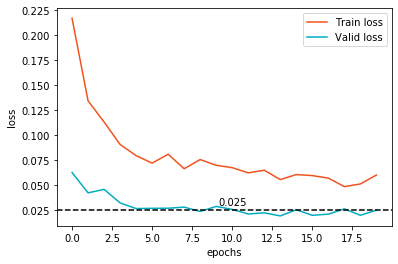

In [1079]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
          conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, conv_architecture="CPB",
          learning_rate=0.001, conv_padding=1, conv_activation="relu", dense_activation="relu",
          optimizer="Adam")
pprint(net.shapes)
print(net.count_parameters())
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 20)
plot_convergence(train_losses, valid_losses);

The valid loss is a bit higher in the end but the convergence seems faster.

In the next example I use a different optimization algorithm AdamW with weight decay of 0.01: 

[('input', 1, 224, 224),
 ('conv2d-01', 32, 224, 224),
 ('relu-01', 32, 224, 224),
 ('maxpool2d-01', 32, 112, 112),
 ('batchnorm-01', 32, 112, 112),
 ('conv2d-02', 32, 112, 112),
 ('relu-02', 32, 112, 112),
 ('maxpool2d-02', 32, 56, 56),
 ('batchnorm-02', 32, 56, 56),
 ('conv2d-03', 64, 56, 56),
 ('relu-03', 64, 56, 56),
 ('maxpool2d-03', 64, 28, 28),
 ('batchnorm-03', 64, 28, 28),
 ('conv2d-04', 64, 28, 28),
 ('relu-04', 64, 28, 28),
 ('maxpool2d-04', 64, 14, 14),
 ('batchnorm-04', 64, 14, 14),
 ('flatten', 12544),
 ('linear-01', 1024),
 ('relu-01', 1024),
 ('dropout-01', 1024),
 ('linear-02', 512),
 ('relu-02', 512),
 ('dropout-02', 512),
 ('output', 136)]
(13506024, 13506024)
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 303.1 Running loss: 0.219 Elapsed time: 11.4 seconds 
Epoch: 1/20 Training loss: 0.219 Valid loss: 0.071
Epoch completion: 100.0% Images per second: 285.9 Running loss: 0.138 Elapsed time: 24.2 seconds 
Epoch: 2/20 Training lo

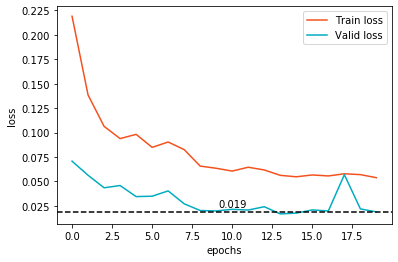

In [1080]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
          conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, conv_architecture="CPB",
          learning_rate=0.001, conv_padding=1, conv_activation="relu", dense_activation="relu",
          optimizer="AdamW", weight_decay=0.01)
pprint(net.shapes)
print(net.count_parameters())
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 20)
plot_convergence(train_losses, valid_losses);

And now with SGD with a momentum of 0.9 without weight decay:

[('input', 1, 224, 224),
 ('conv2d-01', 32, 224, 224),
 ('relu-01', 32, 224, 224),
 ('maxpool2d-01', 32, 112, 112),
 ('batchnorm-01', 32, 112, 112),
 ('conv2d-02', 32, 112, 112),
 ('relu-02', 32, 112, 112),
 ('maxpool2d-02', 32, 56, 56),
 ('batchnorm-02', 32, 56, 56),
 ('conv2d-03', 64, 56, 56),
 ('relu-03', 64, 56, 56),
 ('maxpool2d-03', 64, 28, 28),
 ('batchnorm-03', 64, 28, 28),
 ('conv2d-04', 64, 28, 28),
 ('relu-04', 64, 28, 28),
 ('maxpool2d-04', 64, 14, 14),
 ('batchnorm-04', 64, 14, 14),
 ('flatten', 12544),
 ('linear-01', 1024),
 ('relu-01', 1024),
 ('dropout-01', 1024),
 ('linear-02', 512),
 ('relu-02', 512),
 ('dropout-02', 512),
 ('output', 136)]
(13506024, 13506024)
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 316.1 Running loss: 0.479 Elapsed time: 11.0 seconds 
Epoch: 1/20 Training loss: 0.479 Valid loss: 0.111
Epoch completion: 100.0% Images per second: 298.5 Running loss: 0.274 Elapsed time: 23.2 seconds 
Epoch: 2/20 Training lo

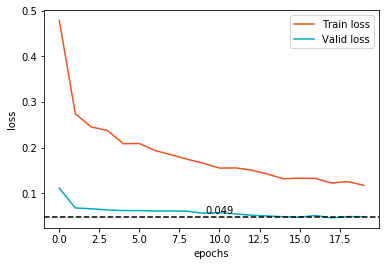

In [1082]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
          conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, conv_architecture="CPB",
          learning_rate=0.001, conv_padding=1, conv_activation="relu", dense_activation="relu",
          optimizer="SGD", weight_decay=0.01)
pprint(net.shapes)
print(net.count_parameters())
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 20)
plot_convergence(train_losses, valid_losses);

The overall convergence with SGD is much slower than with Adam optimizers.

Let's retry with Adam and a weight decay of 0.01:

[('input', 1, 224, 224),
 ('conv2d-01', 32, 224, 224),
 ('relu-01', 32, 224, 224),
 ('maxpool2d-01', 32, 112, 112),
 ('batchnorm-01', 32, 112, 112),
 ('conv2d-02', 32, 112, 112),
 ('relu-02', 32, 112, 112),
 ('maxpool2d-02', 32, 56, 56),
 ('batchnorm-02', 32, 56, 56),
 ('conv2d-03', 64, 56, 56),
 ('relu-03', 64, 56, 56),
 ('maxpool2d-03', 64, 28, 28),
 ('batchnorm-03', 64, 28, 28),
 ('conv2d-04', 64, 28, 28),
 ('relu-04', 64, 28, 28),
 ('maxpool2d-04', 64, 14, 14),
 ('batchnorm-04', 64, 14, 14),
 ('flatten', 12544),
 ('linear-01', 1024),
 ('relu-01', 1024),
 ('dropout-01', 1024),
 ('linear-02', 512),
 ('relu-02', 512),
 ('dropout-02', 512),
 ('output', 136)]
(13506024, 13506024)
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 305.3 Running loss: 0.204 Elapsed time: 11.3 seconds 
Epoch: 1/20 Training loss: 0.204 Valid loss: 0.058
Epoch completion: 100.0% Images per second: 289.9 Running loss: 0.141 Elapsed time: 23.9 seconds 
Epoch: 2/20 Training lo

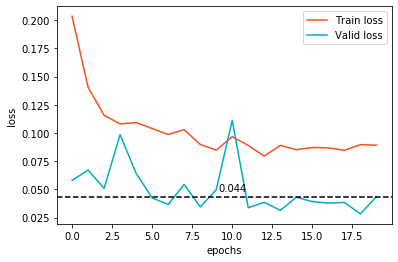

In [1083]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
          conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, conv_architecture="CPB",
          learning_rate=0.001, conv_padding=1, conv_activation="relu", dense_activation="relu",
          optimizer="Adam", weight_decay=0.01)
pprint(net.shapes)
print(net.count_parameters())
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 20)
plot_convergence(train_losses, valid_losses);

Using weight decay with standard Adam leads to worse convergence. I will finally stick with AdamW variant with a weight decay of 0.01.

The next experiment tries to use the decreasing kernel size strategy for convolutional layers. With max-pooling layer the dimension of the image is reduced by a factor of two. This means that a 3x3 kernel size on the second layer actually has a 6x6 pixels window on the original image, twice as much as the first convolutional layer. By reducing the kernel size we somehow force convolutional layers to focus on smaller regions of original image. The last 1x1 kernel size layer is mostly a cross-feature map operations. 

Doing so the number of extracted features increases to 14400 and the number of parameters to be trained is now 15.4 millions:

[('input', 1, 224, 224),
 ('conv2d-01', 32, 223, 223),
 ('relu-01', 32, 223, 223),
 ('maxpool2d-01', 32, 111, 111),
 ('batchnorm-01', 32, 111, 111),
 ('conv2d-02', 32, 111, 111),
 ('relu-02', 32, 111, 111),
 ('maxpool2d-02', 32, 55, 55),
 ('batchnorm-02', 32, 55, 55),
 ('conv2d-03', 64, 56, 56),
 ('relu-03', 64, 56, 56),
 ('maxpool2d-03', 64, 28, 28),
 ('batchnorm-03', 64, 28, 28),
 ('conv2d-04', 64, 30, 30),
 ('relu-04', 64, 30, 30),
 ('maxpool2d-04', 64, 15, 15),
 ('batchnorm-04', 64, 15, 15),
 ('flatten', 14400),
 ('linear-01', 1024),
 ('relu-01', 1024),
 ('dropout-01', 1024),
 ('linear-02', 512),
 ('relu-02', 512),
 ('dropout-02', 512),
 ('output', 136)]
(15363784, 15363784)
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 292.4 Running loss: 0.202 Elapsed time: 11.8 seconds 
Epoch: 1/20 Training loss: 0.202 Valid loss: 0.071
Epoch completion: 100.0% Images per second: 282.0 Running loss: 0.129 Elapsed time: 24.6 seconds 
Epoch: 2/20 Training lo

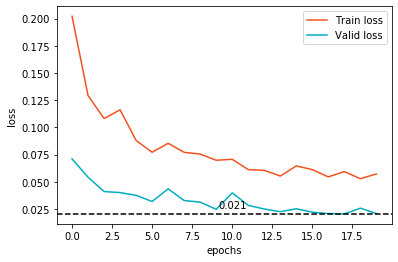

In [1086]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
          conv_kernel_size=[4, 3, 2, 1], pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
          conv_architecture="CPB", learning_rate=0.001, conv_padding=1, conv_activation="relu", 
          dense_activation="relu", optimizer="AdamW", weight_decay=0.01)
pprint(net.shapes)
print(net.count_parameters())
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 20)
plot_convergence(train_losses, valid_losses);

This architecture also present a good convergence.

Let's try now with a different architecture where batch normalization and maxpooling are only applied after two consecutive convolutional layers (and non-linear activation). In order to prevent the number of parameters from exploding, the kernel size of max-pooling is increased to 4x4 with a stride of 4 to avoid overlapping. The number of extracted features and parameters decrease respectively to 12544 and 13.5 millions:

[('input', 1, 224, 224),
 ('conv2d-01', 32, 224, 224),
 ('relu-01', 32, 224, 224),
 ('conv2d-02', 32, 224, 224),
 ('relu-02', 32, 224, 224),
 ('maxpool2d-02', 32, 56, 56),
 ('batchnorm-02', 32, 56, 56),
 ('conv2d-03', 64, 56, 56),
 ('relu-03', 64, 56, 56),
 ('conv2d-04', 64, 56, 56),
 ('relu-04', 64, 56, 56),
 ('maxpool2d-04', 64, 14, 14),
 ('batchnorm-04', 64, 14, 14),
 ('flatten', 12544),
 ('linear-01', 1024),
 ('relu-01', 1024),
 ('dropout-01', 1024),
 ('linear-02', 512),
 ('relu-02', 512),
 ('dropout-02', 512),
 ('output', 136)]
(13505832, 13505832)
Fitting the model using cuda:0 as device.
Epoch completion: 100.0% Images per second: 166.0 Running loss: 0.227 Elapsed time: 20.9 seconds 
Epoch: 1/20 Training loss: 0.227 Valid loss: 0.082
Epoch completion: 100.0% Images per second: 159.1 Running loss: 0.134 Elapsed time: 43.5 seconds 
Epoch: 2/20 Training loss: 0.134 Valid loss: 0.053
Epoch completion: 100.0% Images per second: 157.3 Running loss: 0.104 Elapsed time: 66.0 seconds 
Ep

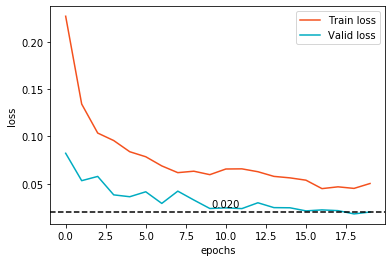

In [1093]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
          conv_kernel_size=3, pool_kernel_size=4, pool_stride=4, dropout_rate=0.2, conv_architecture="CCPB",
          learning_rate=0.001, conv_padding=1, conv_activation="relu", dense_activation="relu",
          optimizer="AdamW", weight_decay=0.01)
pprint(net.shapes)
print(net.count_parameters())
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 20)
plot_convergence(train_losses, valid_losses);

This architecture seems also quite good.

### Final training of best candidates

I will go with 3 different architectures for a longer training process:

- simple: 4 layers 32, 32, 64, 64 with kernel size 3x3 and with conv2d-pooling-batchnorm
- decreasing kernel size: 4 layers 32, 32, 64, 64 with decreaseing kernel size 4x4, 3x3, 2x2 and 1x1 and with conv2-pooling-batchnorm
- two consecutive conv2d: 4 layers 32, 32, 64, 64 with kernel size 3x3 and with conv2d-conv2d-pooling-batchnorm

The **simple** architecture:

Net(
  (cnn): Module(
    (extractor): Sequential(
      (conv2d-01): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-01): ReLU()
      (maxpool2d-01): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-01): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d-02): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-02): ReLU()
      (maxpool2d-02): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-02): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d-03): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-03): ReLU()
      (maxpool2d-03): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-03): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d-04): Conv2d(

Epoch completion: 100.0% Images per second: 271.5 Running loss: 0.044 Elapsed time: 548.3 seconds 
Epoch: 43/200 Training loss: 0.044 Valid loss: 0.017
Epoch completion: 100.0% Images per second: 271.3 Running loss: 0.045 Elapsed time: 561.4 seconds 
Epoch: 44/200 Training loss: 0.045 Valid loss: 0.014
Epoch completion: 100.0% Images per second: 270.9 Running loss: 0.039 Elapsed time: 575.2 seconds 
Epoch: 45/200 Training loss: 0.039 Valid loss: 0.014
Epoch completion: 100.0% Images per second: 270.6 Running loss: 0.057 Elapsed time: 588.4 seconds 
Epoch: 46/200 Training loss: 0.057 Valid loss: 0.016
Epoch completion: 100.0% Images per second: 270.5 Running loss: 0.037 Elapsed time: 601.6 seconds 
Epoch: 47/200 Training loss: 0.037 Valid loss: 0.015
Epoch completion: 100.0% Images per second: 270.3 Running loss: 0.040 Elapsed time: 614.8 seconds 
Epoch: 48/200 Training loss: 0.040 Valid loss: 0.016
Epoch completion: 100.0% Images per second: 270.1 Running loss: 0.041 Elapsed time: 628.

Epoch completion: 100.0% Images per second: 270.6 Running loss: 0.029 Elapsed time: 1240.9 seconds 
Epoch: 97/200 Training loss: 0.029 Valid loss: 0.015
Epoch completion: 100.0% Images per second: 270.6 Running loss: 0.031 Elapsed time: 1253.6 seconds 
Epoch: 98/200 Training loss: 0.031 Valid loss: 0.013
Epoch completion: 100.0% Images per second: 270.6 Running loss: 0.033 Elapsed time: 1266.5 seconds 
Epoch: 99/200 Training loss: 0.033 Valid loss: 0.014
Epoch completion: 100.0% Images per second: 270.6 Running loss: 0.027 Elapsed time: 1279.3 seconds 
Epoch: 100/200 Training loss: 0.027 Valid loss: 0.011
Epoch completion: 100.0% Images per second: 270.6 Running loss: 0.026 Elapsed time: 1292.1 seconds 
Epoch: 101/200 Training loss: 0.026 Valid loss: 0.011
Epoch completion: 100.0% Images per second: 270.6 Running loss: 0.026 Elapsed time: 1304.9 seconds 
Epoch: 102/200 Training loss: 0.026 Valid loss: 0.011
Epoch completion: 100.0% Images per second: 270.6 Running loss: 0.025 Elapsed t

Epoch completion: 100.0% Images per second: 272.4 Running loss: 0.020 Elapsed time: 1906.2 seconds 
Epoch: 150/200 Training loss: 0.020 Valid loss: 0.009
Epoch completion: 100.0% Images per second: 272.5 Running loss: 0.021 Elapsed time: 1918.7 seconds 
Epoch: 151/200 Training loss: 0.021 Valid loss: 0.009
Epoch completion: 100.0% Images per second: 272.5 Running loss: 0.020 Elapsed time: 1931.1 seconds 
Epoch: 152/200 Training loss: 0.020 Valid loss: 0.011
Epoch completion: 100.0% Images per second: 272.5 Running loss: 0.022 Elapsed time: 1943.6 seconds 
Epoch: 153/200 Training loss: 0.022 Valid loss: 0.012
Epoch completion: 100.0% Images per second: 272.5 Running loss: 0.021 Elapsed time: 1956.2 seconds 
Epoch: 154/200 Training loss: 0.021 Valid loss: 0.010
Epoch completion: 100.0% Images per second: 272.6 Running loss: 0.019 Elapsed time: 1968.7 seconds 
Epoch: 155/200 Training loss: 0.019 Valid loss: 0.009
Epoch completion: 100.0% Images per second: 272.6 Running loss: 0.020 Elapse

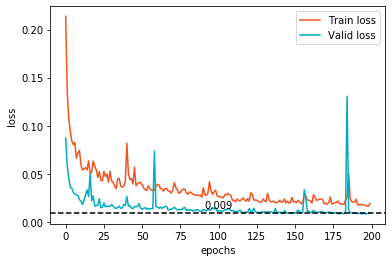

In [1096]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
          conv_kernel_size=3, pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, conv_architecture="CPB",
          learning_rate=0.001, conv_padding=1, conv_activation="relu", dense_activation="relu",
          optimizer="AdamW", weight_decay=0.01)
print(net)
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 200)
plot_convergence(train_losses, valid_losses);
net.save('./saved_models/simple.pt')

The **decreasing kernel size** architecture:

Net(
  (cnn): Module(
    (extractor): Sequential(
      (conv2d-01): Conv2d(1, 32, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
      (relu-01): ReLU()
      (maxpool2d-01): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-01): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d-02): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-02): ReLU()
      (maxpool2d-02): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-02): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d-03): Conv2d(32, 64, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
      (relu-03): ReLU()
      (maxpool2d-03): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-03): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d-04): Conv2d(

Epoch completion: 100.0% Images per second: 271.4 Running loss: 0.045 Elapsed time: 548.5 seconds 
Epoch: 43/200 Training loss: 0.045 Valid loss: 0.026
Epoch completion: 100.0% Images per second: 271.3 Running loss: 0.042 Elapsed time: 561.4 seconds 
Epoch: 44/200 Training loss: 0.042 Valid loss: 0.018
Epoch completion: 100.0% Images per second: 271.3 Running loss: 0.048 Elapsed time: 574.2 seconds 
Epoch: 45/200 Training loss: 0.048 Valid loss: 0.018
Epoch completion: 100.0% Images per second: 271.3 Running loss: 0.038 Elapsed time: 587.0 seconds 
Epoch: 46/200 Training loss: 0.038 Valid loss: 0.018
Epoch completion: 100.0% Images per second: 271.4 Running loss: 0.042 Elapsed time: 599.6 seconds 
Epoch: 47/200 Training loss: 0.042 Valid loss: 0.019
Epoch completion: 100.0% Images per second: 271.3 Running loss: 0.052 Elapsed time: 612.4 seconds 
Epoch: 48/200 Training loss: 0.052 Valid loss: 0.021
Epoch completion: 100.0% Images per second: 271.4 Running loss: 0.055 Elapsed time: 625.

Epoch completion: 100.0% Images per second: 272.0 Running loss: 0.027 Elapsed time: 1234.5 seconds 
Epoch: 97/200 Training loss: 0.027 Valid loss: 0.014
Epoch completion: 100.0% Images per second: 272.0 Running loss: 0.027 Elapsed time: 1247.2 seconds 
Epoch: 98/200 Training loss: 0.027 Valid loss: 0.014
Epoch completion: 100.0% Images per second: 272.0 Running loss: 0.025 Elapsed time: 1259.9 seconds 
Epoch: 99/200 Training loss: 0.025 Valid loss: 0.014
Epoch completion: 100.0% Images per second: 272.1 Running loss: 0.026 Elapsed time: 1272.5 seconds 
Epoch: 100/200 Training loss: 0.026 Valid loss: 0.013
Epoch completion: 100.0% Images per second: 272.1 Running loss: 0.029 Elapsed time: 1285.1 seconds 
Epoch: 101/200 Training loss: 0.029 Valid loss: 0.015
Epoch completion: 100.0% Images per second: 272.1 Running loss: 0.028 Elapsed time: 1297.8 seconds 
Epoch: 102/200 Training loss: 0.028 Valid loss: 0.014
Epoch completion: 100.0% Images per second: 272.1 Running loss: 0.031 Elapsed t

Epoch completion: 100.0% Images per second: 273.0 Running loss: 0.023 Elapsed time: 1902.4 seconds 
Epoch: 150/200 Training loss: 0.023 Valid loss: 0.012
Epoch completion: 100.0% Images per second: 273.0 Running loss: 0.023 Elapsed time: 1914.9 seconds 
Epoch: 151/200 Training loss: 0.023 Valid loss: 0.027
Epoch completion: 100.0% Images per second: 273.0 Running loss: 0.024 Elapsed time: 1927.4 seconds 
Epoch: 152/200 Training loss: 0.024 Valid loss: 0.012
Epoch completion: 100.0% Images per second: 273.0 Running loss: 0.026 Elapsed time: 1940.1 seconds 
Epoch: 153/200 Training loss: 0.026 Valid loss: 0.013
Epoch completion: 100.0% Images per second: 273.0 Running loss: 0.026 Elapsed time: 1952.7 seconds 
Epoch: 154/200 Training loss: 0.026 Valid loss: 0.013
Epoch completion: 100.0% Images per second: 273.1 Running loss: 0.027 Elapsed time: 1965.2 seconds 
Epoch: 155/200 Training loss: 0.027 Valid loss: 0.013
Epoch completion: 100.0% Images per second: 273.1 Running loss: 0.023 Elapse

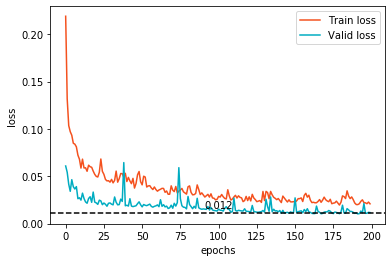

In [1097]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
          conv_kernel_size=[4, 3, 2, 1], pool_kernel_size=2, pool_stride=2, dropout_rate=0.2, 
          conv_architecture="CPB", learning_rate=0.001, conv_padding=1, conv_activation="relu", 
          dense_activation="relu", optimizer="AdamW", weight_decay=0.01)
print(net)
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 200)
plot_convergence(train_losses, valid_losses);
net.save('./saved_models/decreasing_kernel_size.pt')

The **two consecutive conv2d** architecture:

Net(
  (cnn): Module(
    (extractor): Sequential(
      (conv2d-01): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-01): ReLU()
      (conv2d-02): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-02): ReLU()
      (maxpool2d-02): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-02): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d-03): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-03): ReLU()
      (conv2d-04): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-04): ReLU()
      (maxpool2d-04): MaxPool2d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-04): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (flatten): Flatten()
    )
    (regressor): Sequential(
      (linear-01): Linear(in_features=12544, out_featu

Epoch completion: 100.0% Images per second: 153.7 Running loss: 0.036 Elapsed time: 1036.4 seconds 
Epoch: 46/200 Training loss: 0.036 Valid loss: 0.017
Epoch completion: 100.0% Images per second: 153.7 Running loss: 0.040 Elapsed time: 1058.8 seconds 
Epoch: 47/200 Training loss: 0.040 Valid loss: 0.018
Epoch completion: 100.0% Images per second: 153.7 Running loss: 0.040 Elapsed time: 1081.1 seconds 
Epoch: 48/200 Training loss: 0.040 Valid loss: 0.019
Epoch completion: 100.0% Images per second: 153.7 Running loss: 0.039 Elapsed time: 1103.4 seconds 
Epoch: 49/200 Training loss: 0.039 Valid loss: 0.019
Epoch completion: 100.0% Images per second: 153.8 Running loss: 0.045 Elapsed time: 1125.8 seconds 
Epoch: 50/200 Training loss: 0.045 Valid loss: 0.017
Epoch completion: 100.0% Images per second: 153.8 Running loss: 0.034 Elapsed time: 1148.2 seconds 
Epoch: 51/200 Training loss: 0.034 Valid loss: 0.017
Epoch completion: 100.0% Images per second: 153.8 Running loss: 0.032 Elapsed time

Epoch completion: 100.0% Images per second: 154.3 Running loss: 0.031 Elapsed time: 2221.9 seconds 
Epoch: 99/200 Training loss: 0.031 Valid loss: 0.014
Epoch completion: 100.0% Images per second: 154.3 Running loss: 0.029 Elapsed time: 2244.0 seconds 
Epoch: 100/200 Training loss: 0.029 Valid loss: 0.015
Epoch completion: 100.0% Images per second: 154.3 Running loss: 0.032 Elapsed time: 2266.1 seconds 
Epoch: 101/200 Training loss: 0.032 Valid loss: 0.019
Epoch completion: 100.0% Images per second: 154.3 Running loss: 0.029 Elapsed time: 2288.1 seconds 
Epoch: 102/200 Training loss: 0.029 Valid loss: 0.014
Epoch completion: 100.0% Images per second: 154.4 Running loss: 0.030 Elapsed time: 2310.1 seconds 
Epoch: 103/200 Training loss: 0.030 Valid loss: 0.014
Epoch completion: 100.0% Images per second: 154.4 Running loss: 0.027 Elapsed time: 2332.2 seconds 
Epoch: 104/200 Training loss: 0.027 Valid loss: 0.013
Epoch completion: 100.0% Images per second: 154.4 Running loss: 0.031 Elapsed

Epoch completion: 100.0% Images per second: 155.3 Running loss: 0.026 Elapsed time: 3388.2 seconds 
Epoch: 152/200 Training loss: 0.026 Valid loss: 0.013
Epoch completion: 100.0% Images per second: 155.3 Running loss: 0.023 Elapsed time: 3410.2 seconds 
Epoch: 153/200 Training loss: 0.023 Valid loss: 0.012
Epoch completion: 100.0% Images per second: 155.3 Running loss: 0.023 Elapsed time: 3432.3 seconds 
Epoch: 154/200 Training loss: 0.023 Valid loss: 0.011
Epoch completion: 100.0% Images per second: 155.3 Running loss: 0.024 Elapsed time: 3454.3 seconds 
Epoch: 155/200 Training loss: 0.024 Valid loss: 0.011
Epoch completion: 100.0% Images per second: 155.4 Running loss: 0.024 Elapsed time: 3476.2 seconds 
Epoch: 156/200 Training loss: 0.024 Valid loss: 0.012
Epoch completion: 100.0% Images per second: 155.4 Running loss: 0.025 Elapsed time: 3498.3 seconds 
Epoch: 157/200 Training loss: 0.025 Valid loss: 0.011
Epoch completion: 100.0% Images per second: 155.4 Running loss: 0.034 Elapse

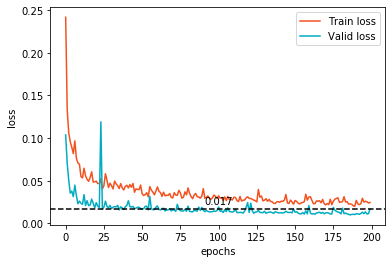

In [1098]:
net = Net(nb_features_map=[32, 32, 64, 64], size_linear_layers=[1024, 512], 
          conv_kernel_size=3, pool_kernel_size=4, pool_stride=4, dropout_rate=0.2, conv_architecture="CCPB",
          learning_rate=0.001, conv_padding=1, conv_activation="relu", dense_activation="relu",
          optimizer="AdamW", weight_decay=0.01)
print(net)
train_losses, valid_losses, elapsed_times = net.fit(train_loader, test_loader, 200)
plot_convergence(train_losses, valid_losses);
net.save('./saved_models/two_consecutive_conv2d.pt')

The first try was the best and has reached a loss of 0.009 after 200 epochs. this is the network we will use for the rest of the project:

In [1101]:
net = Net.load('./saved_models/simple.pt')
print(net)

Net(
  (cnn): Module(
    (extractor): Sequential(
      (conv2d-01): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-01): ReLU()
      (maxpool2d-01): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-01): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d-02): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-02): ReLU()
      (maxpool2d-02): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-02): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d-03): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (relu-03): ReLU()
      (maxpool2d-03): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (batchnorm-03): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2d-04): Conv2d(

## Test data

See how your model performs on previously unseen, test data. We've already loaded and transformed this data, similar to the training data. Next, run your trained model on these images to see what kind of keypoints are produced. You should be able to see if your model is fitting each new face it sees, if the points are distributed randomly, or if the points have actually overfitted the training data and do not generalize.

In [1111]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output(net, test_loader)

# print(test_images.data.size())
# print(test_outputs.data.size())
# print(gt_pts.size())

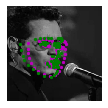

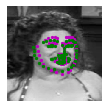

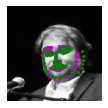

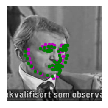

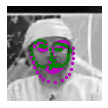

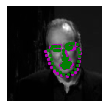

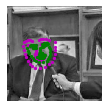

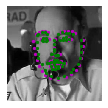

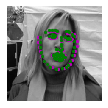

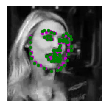

In [1112]:
visualize_output(test_images, test_outputs, gt_pts)

After you've trained a well-performing model, answer the following questions so that we have some insight into your training and architecture selection process. Answering all questions is required to pass this project.

### Question 1: What optimization and loss functions did you choose and why?


**Answer**: I have used a mean square error loss function which is adapted for regression. I use a mean reduction, I haven't tried with a sum reduction. My understanting is that mean reduction leads to lower loss and then a smaller weight during back propagation. I have made some tests with Adam and SGD optimizer (with 0.9 momentum) but found that convergence with Adam were faster. I opted for the AdamW variant with weight decay as weight decay with Adam leads to a worse convergence of loss.

### Question 2: What kind of network architecture did you start with and how did it change as you tried different architectures? Did you decide to add more convolutional layers or any layers to avoid overfitting the data?

**Answer**: I started with a 4-layer architecture like NaimishNet where each layer was (conv-relu-maxpool) but with only 32, 32, 64 and 64 feature maps, batch size of 10 and with data augmentation (random rotate, flip and crop). As I was failing to have a good convergence, I have tried with different, more complex architectures (VGG like). I have kept 4 layers with NaimishNet-like architecture to avoid reducing the number of features. I have tested deeper network when chaining 2 or 3 convolution layers (like VGG16) before pooling to avoid too high dimension reduction between each block. Most of my test results have been poluted by my issue in data augmentation. After fixing it I kept a simple 4-layer network.

I finally kept three different architectures with 4 convolutional layers each and zero-padding for convolution layers:

- simple (conv-activation-pool-batchnorm) x 4 with constant kernel size of 3x3 on convolutional layers and 2x2 kernel for maxpooling with stride 2.
- (conv-activation-pool-batchnorm) x 4 with decreasing kernel size 4x4, 3x3, 2x2, 1x1 on covolutional layers and 2x2 kernel for maxpooling with stride 2.
- (conv-activation-conv-activation-pool-batchnorm) x 2 with constant kernel size of 3x3 on convolutional layers but increased kernel size of 4x4 for max pooling with stride 4 to keep the number of features and parameters on par with two previous architectures.

To avoid overfitting I am using data augmentation which virtually increase the number of training samples, have used a combination of batch normalization and dropout and use the AdamW optimizer variant with weight decay of 0.01.

### Question 3: How did you decide on the number of epochs and batch_size to train your model?

**Answer**: Number of epochs has been determined by having a look at convergence history. Without data augmentation I needed 20 epochs to reach an acceptable accuracy. With data augmentation I needed up to 200 epochs, all other things being equal. I started with batch size 10 and predicted key points on few faces were not good. I have augmented it up to 96 for simple networks but need to reduce its size down to 8 for more complex architecture due to the 4GB VRAM memory limit of my GPU. Above 32 I have seen that accuracy was not increasing and sometimes even dropped. But my testing loss has been divided by two between a batch size of 10 and 32. I kept 32 batch size as it was a good compromise between convergence and the limits of my GPU.

## Feature Visualization

Sometimes, neural networks are thought of as a black box, given some input, they learn to produce some output. CNN's are actually learning to recognize a variety of spatial patterns and you can visualize what each convolutional layer has been trained to recognize by looking at the weights that make up each convolutional kernel and applying those one at a time to a sample image. This technique is called feature visualization and it's useful for understanding the inner workings of a CNN.

In the cell below, you can see how to extract a single filter (by index) from your first convolutional layer. The filter should appear as a grayscale grid.

(32, 1, 3, 3)
[[-0.12994175 -0.2723095  -0.04420786]
 [-0.0047633   0.159171   -0.2428874 ]
 [ 0.2292143   0.22131833  0.26609987]]
(3, 3)


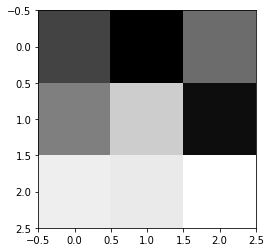

In [1113]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.cnn.extractor[0].weight.data

w = weights1.numpy()
print(w.shape)

filter_index = 28

print(w[filter_index][0])
print(w[filter_index][0].shape)

# display the filter weights
plt.imshow(w[filter_index][0], cmap='gray')


## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**. So, feature maps are just sets of filtered images; they are the images produced by applying a convolutional kernel to an input image. These maps show us the features that the different layers of the neural network learn to extract. For example, you might imagine a convolutional kernel that detects the vertical edges of a face or another one that detects the corners of eyes. You can see what kind of features each of these kernels detects by applying them to an image. One such example is shown below; from the way it brings out the lines in an the image, you might characterize this as an edge detection filter.

<img src='images/feature_map_ex.png' width=50% height=50%/>


Next, choose a test image and filter it with one of the convolutional kernels in your trained CNN; look at the filtered output to get an idea what that particular kernel detects.

### TODO: Filter an image to see the effect of a convolutional kernel
---

The functions below enable to visualize the input image after a series of filtering. It relies on a fonction I have implemented on the neural network class to extract a sub-model up to a certain layer.

The function then takes as an input the name of the last layer we want to have included in the sub-model. The sub-model is then executed to produce as an output the feature maps which are then visualized thanks to matplotlib plotting capability. Each filtered image is plotted against the last convolution layer kernel that has been applied on that picture.

It is then possible to visualize right after a convolutional layer or after the activation function.

In [1114]:
def plot_maps(model, batch, weights, idx=0, channel=0):
    # Run model
    output = model(batch).data.numpy()
    nb_maps = output.shape[1]
    fig = plt.figure(figsize=(20, nb_maps))
    for i in range(nb_maps * 2):
        if (i % 2 == 0):
            ax = fig.add_subplot(nb_maps/4, 8, i+1)
            ax.imshow(weights[int(i/2), channel, :, :], cmap="gray")
        else:
            ax = fig.add_subplot(nb_maps/4, 8, i+1)
            ax.imshow(output[idx, int(i/2)], cmap="gray")
    fig.tight_layout()

In [1135]:
def plot_submodel_maps(model, layer, batch, idx=0, channel=0):
    # Extract a sub-model up to the specified layer
    submodel = model.sub_model(layer)
    # Get the weights of the last layer with weight (convolutional layer)
    for module in submodel:
        try:
            weights = module.weight.data.numpy()
        except:
            pass
    print(weights.shape)
    plt.imshow(batch[idx, 0].data.numpy(), cmap="gray")
    plot_maps(submodel, batch, weights, idx, channel)

This is a visluaziation after the non-linear activation following the first convolutional layer:

(32, 1, 3, 3)


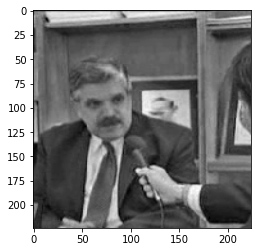

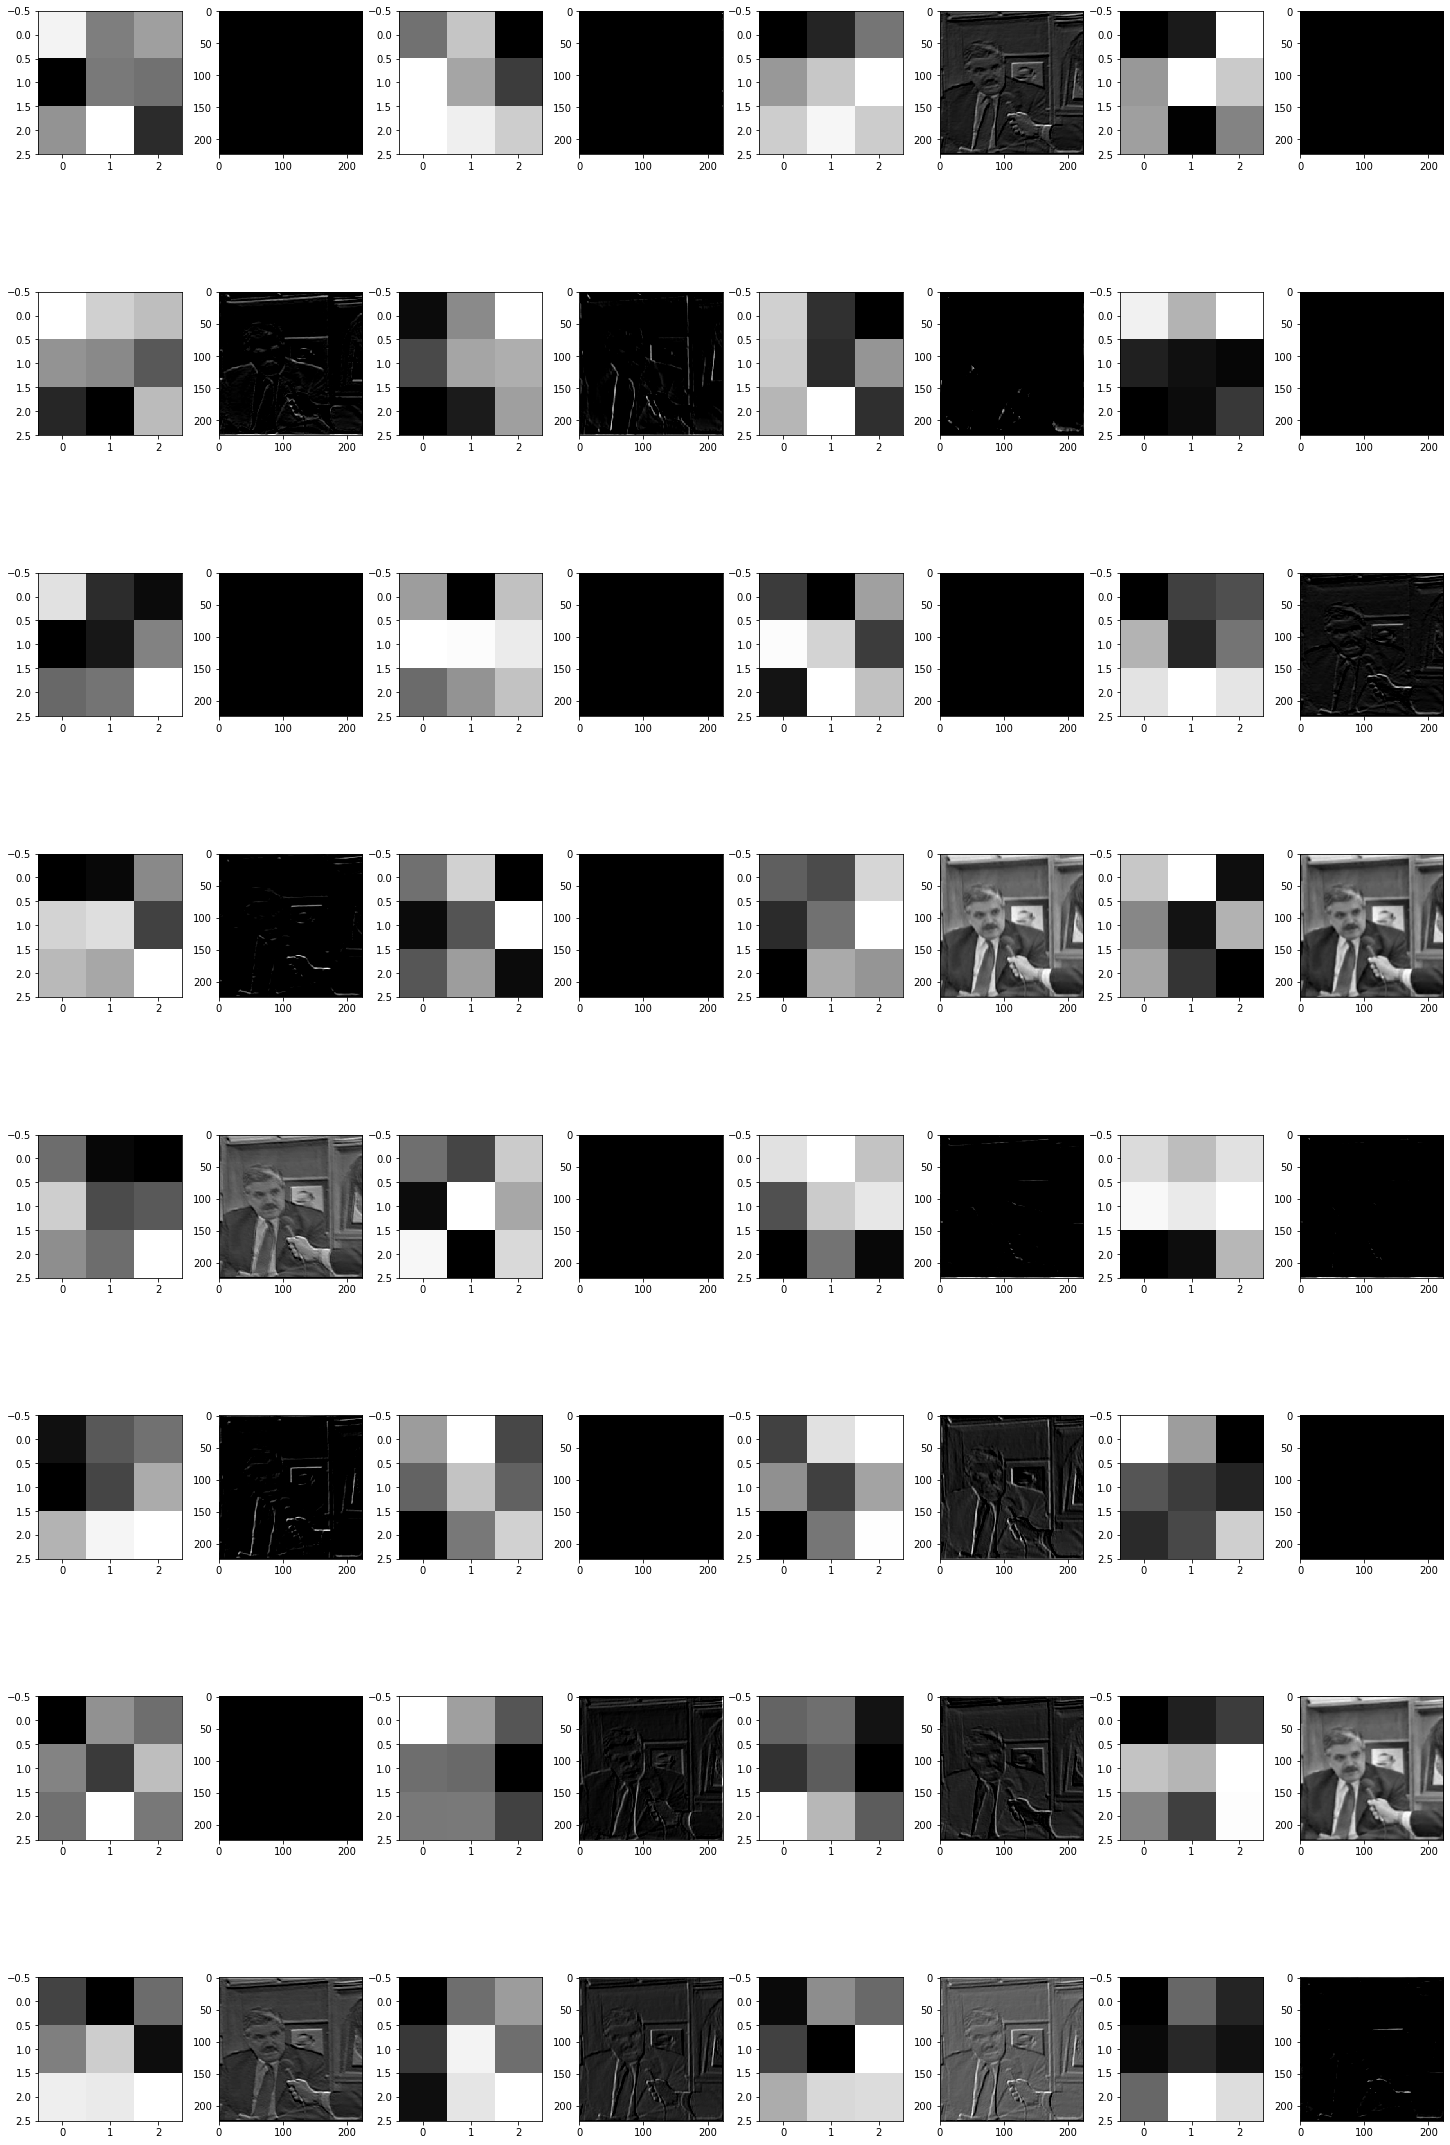

In [1140]:
plot_submodel_maps(net, "cnn.extractor.relu-01", test_images, idx=6, channel=0)

### Question 4: Choose one filter from your trained CNN and apply it to a test image; what purpose do you think it plays? What kind of feature do you think it detects?


**Answer**: In the second row, the first filter detects the horizontal edges while the second one detects vertical edges.

---
## Moving on!

Now that you've defined and trained your model (and saved the best model), you are ready to move on to the last notebook, which combines a face detector with your saved model to create a facial keypoint detection system that can predict the keypoints on *any* face in an image!